# **Voluntapps - Platform Penghubung Relawan dengan Proyek Volunteer**

**Tujuan Proyek**
1. Memberikan kemudahan bagi para volunteer dalam mengakses proyek kerja sosial yang ada di wilayah Indonesia.
2. Mendukung Organisasi dalam menemukan relawan yang memiliki kemampuan yang relevan dengan yang dibutuhkan.
3. Menjadikan platform ini sarana edukasi bagi generasi muda Indonesia dalam meningkatkan keterlibatan sosial melalui kegiatan relawan.

**Rumusan Masalah**
1. Dalam kegiatan kuliah, sebagian besar perguruan tinggi (baik negri maupun swasta) memiliki syarat lulus **Volunteer**, Voluntapps bisa membantu mempermudah para mahasiswa dalam mencari tempat volunteer yang relevan dengan kompetensi yang mereka miliki.
2. Masih banyak mahasiswa yang kesulitan dalam mencari tempat volunteer di daerah yang mereka inginkan, dan juga yang sesuai dengan kemampuan yang mereka miliki.

**Informasi Dataset**

Dataset ini diambil melalui https://github.com/junaediakbar/Capstone-Bangkit-2022-Relasia/blob/master/Machine%20Learning/indorelawan.csv dengan jumlah baris 371, dengan detail kolom:
1. **nomor** = Nomor urut (index)
2. **nama** = Nama organisasi atau proyek relawan
3. **keahlian 1** = Keahlian utama yang dibutuhkan proyek
4. **keahlian 2** = Keahlian tambahan
5. **lokasi** = Lokasi proyek relawan (kota + provinsi)

**Fitur-fitur**
1. **Smart Matching** = Digunakan untuk mencocokkan data relawan dengan keahlian yang dibutuhkan proyek sosial menggunakan TF-IDF Smart Matching
2. **Regression** = Memprediksi skor kecocokan antara data relawan dengan proyek sosial
3. **Clustering** = Mengelompokkan proyek berdasarkan lokasi terdekat → cocok untuk saran lintas kota
4. **Neural Colaborative Filtering** = User menginput data (sebagai volunteer), kemudian di cocokkan dengan keahlian yang dibutuhkan dalam proyek sosial

# Import Library

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


# Data Preparation

In [30]:
df = pd.read_csv("indorelawan.csv")
df.head()

,nomor,nama,keahlian 1,keahlian 2,lokasi
0,1,Karbon Biru,Lingkungan,Pengembangan Masyarakat,"Kota Surabaya, Jawa Timur"
1,2,Rumah Sandar,Pendidikan,Pengembangan Anak Muda,"Kota Depok, Jawa Barat"
2,3,Yayasan PERSEPSI,NaN,NaN,"Kabupaten Klaten, Jawa Tengah"
3,4,Atma Jaya Consultinh Community,Kepemimpinan & Organisasi,Pengembangan Anak Muda,"Kota Administrasi Jakarta Selatan, DKI Jakarta"
4,5,BAZNAS Kota Bandung,Pengembangan Masyarakat,Kesehatan,"Kota Bandung, Jawa Barat"


# Exploratory Data Analysis

In [31]:
df.describe()

,nomor
count,371.000000
mean,186.000000
std,107.242715
min,1.000000
25%,93.500000
50%,186.000000
75%,278.500000
max,371.000000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nomor       371 non-null    int64 
 1   nama        371 non-null    object
 2   keahlian 1  370 non-null    object
 3   keahlian 2  370 non-null    object
 4   lokasi      371 non-null    object
dtypes: int64(1), object(4)
memory usage: 14.6+ KB


In [33]:
df['keahlian 1'] = df['keahlian 1'].str.lower()
df['keahlian 2'] = df['keahlian 2'].str.lower()
df['lokasi'] = df['lokasi'].str.lower()

all_skills = pd.concat([df['keahlian 1'], df['keahlian 2']]).dropna()
skill_counts = all_skills.value_counts().head(10)

**Top Skills yang dibutuhkan dalam Volunteer**

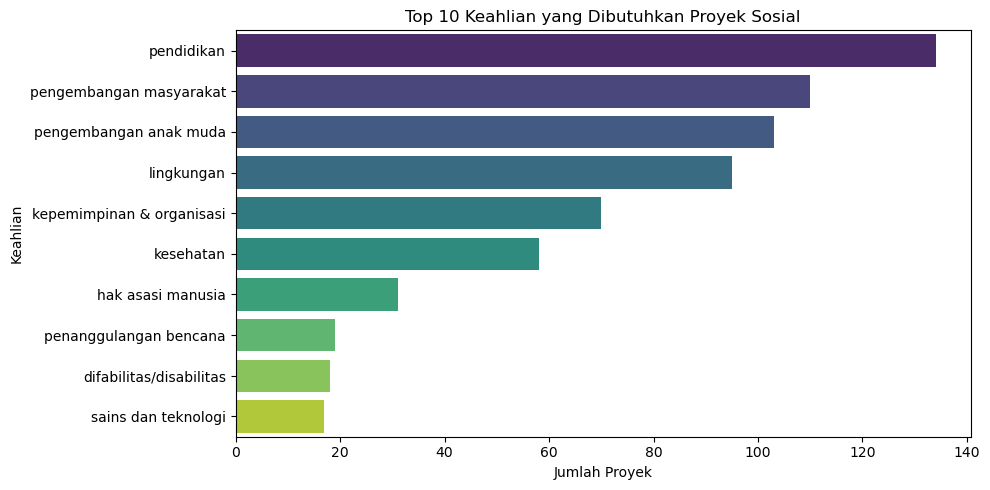

In [34]:
plt.figure(figsize=(10,5))
sns.barplot(x=skill_counts.values, y=skill_counts.index, palette='viridis')
plt.title('Top 10 Keahlian yang Dibutuhkan Proyek Sosial')
plt.xlabel('Jumlah Proyek')
plt.ylabel('Keahlian')
plt.tight_layout()
plt.show()

**Analisis Lokasi**

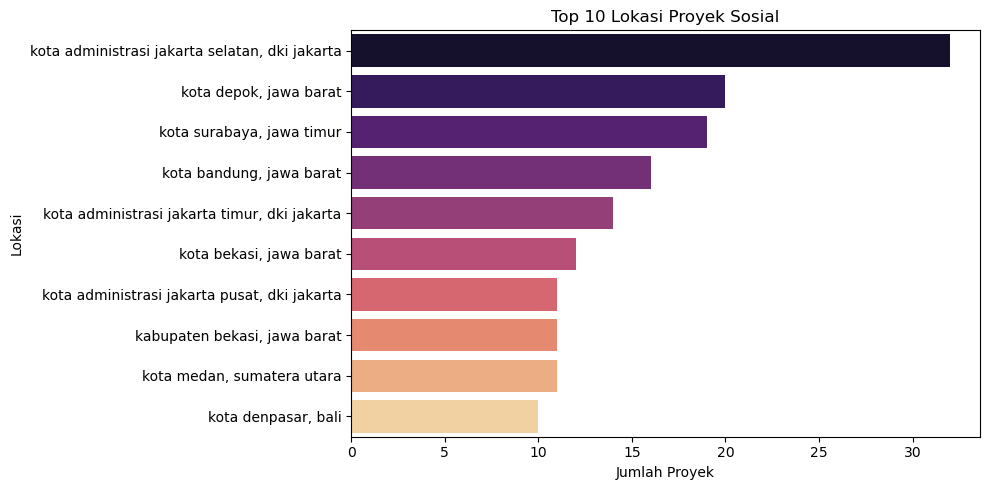

In [35]:
lokasi_counts = df['lokasi'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=lokasi_counts.values, y=lokasi_counts.index, palette='magma')
plt.title('Top 10 Lokasi Proyek Sosial')
plt.xlabel('Jumlah Proyek')
plt.ylabel('Lokasi')
plt.tight_layout()
plt.show()

# Hasil Analisis Dataset Sementara

1. Pada grafik pertama mengenai top 10 keahlian yang dibutuhkan proyek sosial, kita mengetahui bahwa skills yang paling dibutuhkan dalam volunteer berdasarkan dataset indorelawan adalah pendidikan, diikuti oleh pengembangan masyarakat hingga sains dan teknologi pada peringkat ke-10. Ini berarti, relawan dengan kompetensi dalam bidang-bidang tersebut memiliki peluang lebih besar untuk dapat diterima dalam proyek sosial dalam indorelawan.

2. Pada grafik kedua mengenai top 10 lokasi proyek sosial, kita mengetahui bahwa wilayah yang paling banyak memiliki "lowongan" untuk para relawan didominasi oleh daerah jawa, sedangkan yang non-jawa hanyalah Kota Medan dan juga Kota Denpasar. Ini berarti, relawan yang berada disekitar daerah-daerah tersebut memiliki peluang proyek sosial lebih besar daripada yang diluar daerah-daerah tersebut.

# Preprocessing

In [36]:
df_clean = df.dropna(subset=["keahlian 1", "keahlian 2"])
df_clean["keahlian"] = df_clean["keahlian 1"] + ", " + df_clean["keahlian 2"]
df_clean["lokasi_clean"] = df_clean["lokasi"].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True)

volunteer_testing = {
    "nama": "Andi",
    "lokasi": "Kota Depok, Jawa Barat",
    "keahlian": "Pendidikan, Pengembangan Anak Muda",
    "minat": "Pendidikan",
    "ketersediaan": "Weekend"
}

# Smart Matching

In [37]:
import joblib
import os

tfidf = TfidfVectorizer()
project_skills_tfidf = tfidf.fit_transform(df_clean["keahlian"])
volunteer_skill_tfidf = tfidf.transform([volunteer_testing["keahlian"]])

similarity_scores = cosine_similarity(volunteer_skill_tfidf, project_skills_tfidf).flatten()
df_clean["tfidf_smart_score"] = similarity_scores

top_tfidf_matches = df_clean.sort_values("tfidf_smart_score", ascending=False)[["nama", "keahlian", "tfidf_smart_score"]].head(5)
top_tfidf_matches

os.makedirs('tfidf_model', exist_ok=True)
joblib.dump(tfidf, 'tfidf_model/vectorizer.pkl')
joblib.dump(project_skills_tfidf, 'tfidf_model/project_tfidf_matrix.pkl')
joblib.dump(similarity_scores, 'tfidf_model/similarity_scores.pkl')  # opsional

['tfidf_model/similarity_scores.pkl']

# Regression

In [38]:
df_clean["dummy_availability"] = np.random.uniform(0.5, 1.0, size=len(df_clean))
df_clean["total_score"] = 0.7 * df_clean["tfidf_smart_score"] + 0.3 * df_clean["dummy_availability"]
X = df_clean[["tfidf_smart_score", "dummy_availability"]]
y = df_clean["total_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [39]:
import joblib
import os

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

y_test_class = (y_test >= 0.5).astype(int)
lr_preds_class = (lr_preds >= 0.5).astype(int)

cm_lr = confusion_matrix(y_test_class, lr_preds_class)
acc_lr = accuracy_score(y_test_class, lr_preds_class)

print("🔍 Linear Regression:")
print("Confusion Matrix:\n", cm_lr)
print("Accuracy:", round(acc_lr, 3))

os.makedirs('lr_model', exist_ok=True)
joblib.dump(lr_model, 'lr_model/lr_model.pkl')
joblib.dump(tfidf, 'lr_model/vectorizer.pkl')
joblib.dump(project_skills_tfidf, 'lr_model/project_tfidf_matrix.pkl')
joblib.dump(similarity_scores, 'lr_model/similarity_scores.pkl')

🔍 Linear Regression:
Confusion Matrix:
 [[50  0]
 [ 0 24]]
Accuracy: 1.0


['lr_model/similarity_scores.pkl']

**Random Forest**

In [40]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

y_test_class = (y_test >= 0.5).astype(int)
rf_preds_class = (rf_preds >= 0.5).astype(int)

cm_rf = confusion_matrix(y_test_class, rf_preds_class)
acc_rf = accuracy_score(y_test_class, rf_preds_class)

print("\n🌲 Random Forest Regressor:")
print("Confusion Matrix:\n", cm_rf)
print("Accuracy:", round(acc_rf, 3))

os.makedirs('rf_model', exist_ok=True)
joblib.dump(rf_model, 'rf_model/rf_model.pkl')
joblib.dump(tfidf, 'rf_model/vectorizer.pkl')
joblib.dump(project_skills_tfidf, 'rf_model/project_tfidf_matrix.pkl')
joblib.dump(similarity_scores, 'rf_model/similarity_scores.pkl')


🌲 Random Forest Regressor:
Confusion Matrix:
 [[50  0]
 [ 0 24]]
Accuracy: 1.0


['rf_model/similarity_scores.pkl']

# Clustering

In [41]:
vectorizer = TfidfVectorizer()
location_vectors = vectorizer.fit_transform(df_clean["lokasi_clean"])
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(location_vectors)
df_clean["cluster"] = clusters

cluster_summary = df_clean["cluster"].value_counts().sort_index()
cluster_summary_df = pd.DataFrame({
    "Cluster": cluster_summary.index,
    "Jumlah Proyek": cluster_summary.values
})
cluster_summary_df

,Cluster,Jumlah Proyek
0,0,31
1,1,33
2,2,32
3,3,138
4,4,136


# Result Analysis Sementara

Berdasarkan 3 Fitur diatas, kita mengetahui bahwa:

1. Smart Matching (dengan TF-IDF AI Based) berfungsi untuk mencocokkan keahlian relawan dengan keahlian yang dibutuhkan proyek sosial, menggunakan representasi teks berbasis AI (TF-IDF + cosine similarity). Hasilnya adalah top 5 proyek yang memiliki TF-IDF Score 1.00, yang berarti keahlian relawan sangat relevan dengan proyek-proyek tersebut. Contoh proyeknya adalah Zipmex Troops, IYOIN LC Malang, Lingkar Muda, NAHAWAND ALMAJID BOGOR, dan Youth Gakaxy. Fitur ini bisa memberikan rekomendasi yang sangat personal dan akurat berdasarkan kemampuan relawan, dan juga memungkinkan pencocokan meskipun penulisan keahlian berbeda.

2. Model Regression (Linear & Random Forest) digunakan untuk memprediksi skor akhir kecocokan berdasarkan beberapa fitur numerik seperti smart_score dan ketersediaan waktu. Regression digunakan untuk memperkirakan Skor Total Kecocokan antara seorang relawan dan suatu proyek sosial berdasarkan berbagai fitur. Jadi seperti "Seberapa besar kemungkinan relawan ini cocok secara keseluruhan dengan proyek ini?". Dari perbandingan kedua model tersebut, saya memilih Random Forest karena non-linear, dan lebih realistis.

3. K-Means Clustering pada Voluntapps digunakan untuk mengelompokkan proyek sosial berdasarkan lokasi geografis (berdasarkan teks nama kota), agar relawan mendapatkan saran proyek yang paling dekat dengan domisili mereka. Dengan Clustering, para relawan bisa lebih mudah memilih proyek di lokasi yang mereka inginkan.



# Neural Collaborative Filtering

In [42]:
project_encoder = LabelEncoder()
df_clean["project_id"] = project_encoder.fit_transform(df_clean["nomor"])

volunteer_ids = [0] * len(df_clean)
project_ids = df_clean["project_id"].values
num_projects = df_clean["project_id"].nunique()

user_input = Input(shape=(1,))
project_input = Input(shape=(1,))

user_embed = Embedding(input_dim=1, output_dim=5)(user_input)
project_embed = Embedding(input_dim=num_projects + 1, output_dim=5)(project_input)

user_vec = Flatten()(user_embed)
project_vec = Flatten()(project_embed)

concat = Concatenate()([user_vec, project_vec])
dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

ncf_model = Model([user_input, project_input], output)
ncf_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy')

labels = np.ones(len(df_clean))

ncf_model.fit([np.array(volunteer_ids), project_ids], labels, epochs=5, verbose=0)

ncf_preds = ncf_model.predict([np.array(volunteer_ids), project_ids]).flatten()
df_clean["ncf_score"] = ncf_preds

os.makedirs("ncf_model", exist_ok=True)
ncf_model.save("ncf_model/ncf_model.h5")
joblib.dump(project_encoder, "ncf_model/project_encoder.pkl")
joblib.dump(volunteer_ids, "ncf_model/volunteer_ids.pkl")
joblib.dump(project_ids, "ncf_model/project_ids.pkl")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


['ncf_model/project_ids.pkl']

# Input Function

In [ ]:
# Ambil daftar unik keahlian dan lokasi
all_skills = pd.concat([df_clean["keahlian 1"], df_clean["keahlian 2"]]).dropna().unique()
all_skills = sorted(set(skill.strip().lower() for skill in all_skills if isinstance(skill, str)))
categories = sorted(set(df_clean["keahlian 1"].dropna().unique()))
all_locations = sorted(df_clean["lokasi"].dropna().unique())

def rekomendasi_proyek():
    print("Masukkan data volunteer:")
    nama = input("Nama lengkap: ")

    print("\nPilih lokasi Anda dari daftar berikut:")
    for i, loc in enumerate(all_locations):
        print(f"{i+1}. {loc}")
    selected_loc = int(input("Masukkan nomor lokasi: ")) - 1
    lokasi = all_locations[selected_loc]

    print("\nPilih keahlian yang kamu miliki dari daftar berikut:")
    for i, skill in enumerate(all_skills):
        print(f"{i+1}. {skill}")
    selected_indices = input("Masukkan nomor keahlian (pisahkan dengan koma): ")
    selected_skills = [all_skills[int(i)-1] for i in selected_indices.split(",")]
    keahlian = ", ".join(selected_skills)

    print("\nPilih minat/kategori proyek dari daftar berikut:")
    for i, cat in enumerate(categories):
        print(f"{i+1}. {cat}")
    selected_cat = int(input("Masukkan nomor kategori: ")) - 1
    minat = categories[selected_cat]

    volunteer_skill_tfidf = tfidf.transform([keahlian])
    similarity_scores = cosine_similarity(volunteer_skill_tfidf, project_skills_tfidf).flatten()
    df_clean["smart_score"] = similarity_scores

    df_clean["dummy_availability"] = np.random.uniform(0.5, 1.0, size=len(df_clean))
    df_clean["total_score"] = 0.7 * df_clean["smart_score"] + 0.3 * df_clean["dummy_availability"]

    lokasi_vec = vectorizer.transform([lokasi])
    cluster_pred = kmeans.predict(lokasi_vec)[0]
    df_clean["same_cluster"] = df_clean["cluster"] == cluster_pred

    df_clean["final_score"] = (
        0.5 * df_clean["smart_score"] +
        0.2 * df_clean["total_score"] +
        0.2 * df_clean["ncf_score"] +
        0.1 * df_clean["same_cluster"].astype(int)
    )
    df_clean["final_score_pct"] = df_clean["final_score"] * 100

    top_final = df_clean.sort_values("final_score", ascending=False).head(10)

    print("\n🎯 === 10 Rekomendasi Proyek Terbaik Untuk Anda ===")
    for idx, row in top_final.iterrows():
        print(f"{top_final.index.get_loc(idx)+1}. {row['nama']} ({row['lokasi']})")
        print(f"   Keahlian Dibutuhkan : {row['keahlian']}")
        print(f"   Skor Kecocokan      : {row['final_score_pct']:.1f}%")
        print("-" * 80)

rekomendasi_proyek()